<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*VQE algorithm: Application to quantum chemistry*_ 

The latest version of this notebook is available on https://github.com/IBM/qiskit-sdk-py/tree/master/scripts.

For more information about how to use the IBM Q Experience (QX), consult the [Quantum Experience tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Antonio Mezzacapo, Jay Gambetta

### Introduction

One of the earliest and most compelling applications of quantum computation is the idea of using quantum computers to simulate other quantum systems. Quantum simulation of quantum systems encompasses a wide range of tasks, including most significantly:
    
1. Simulation of the time evolution of quantum systems.

2. Computation of ground state properties. 

These applications are especially useful when considering systems of interacting fermions, such as molecules and strongly correlated materials. The computation of ground state properties of fermionic systems is the starting point for mapping out the phase diagram of condensed matter Hamiltonians. It also gives access to the key question of electronic structure problems in quantum chemistry, namely reaction rates. The focus of this notebook is on molecular systems, which are considered to be the ideal bench test for early-stage quantum computers, because of their relevance in chemical applications despite relatively modest sizes. Formally, the ground state problem asks the following:

For some physical Hamiltonian *H*, find the smallest eigenvalue $E_G$, such that $H|\psi_G\rangle=E_G|\psi_G\rangle$, where $|\Psi_G\rangle$ is the eigenvector corresponding to $E_G$.
    
It is known that in general this problem is intractable even on a quantum computer. This means that we cannot expect an efficient quantum algorithm which prepares the ground state of general local Hamiltonians. Despite this limitation, for specific Hamiltonians of interest it might be possible, given physical constraints on the interactions, to solve the above problem efficiently. Currently, at least four different methods exist to approach this problem:

1. Quantum phase estimation: Assuming that we can approximately prepare the state $|\psi_G\rangle$, this routine uses controlled implementations of the Hamiltonian to find its smallest eigenvalue. 
2. Adiabatic theorem of quantum mechanics: The quantum system is adiabatically dragged from being the ground state of a trivial Hamiltonian to the one of the target problem, via slow modulation of the Hamiltonian terms. 
3. Dissipative (non-unitary) quantum operation: It has the ground state of the target system as a fixed point. The non-trivial assumption here is the implementation of the dissipation map on quantum hardware. 
4. Variational quantum eigensolvers: Here we assume that ground state can be represented by a parameterization containing a relatively small number of parameters.

In this notebook we focus on the last method, as this is most likely the simplest to be realized on near-term devices. 

The general idea is to define a parameterization $|\psi(\boldsymbol\theta)\rangle$ of quantum states, and minimize the energy 

$$E(\boldsymbol\theta) = \langle \psi(\boldsymbol\theta)| H |\psi(\boldsymbol\theta)\rangle,$$ 

The key ansatz is that the number of parameters $|\boldsymbol\theta^*|$ that minimizes the energy function scales polynomially with the size (e.g., number of qubits) of the target problem.  

Then, any local fermionic Hamiltonian can be mapped into a sum over pauli operators $P_i$,  

$$H\rightarrow H_P = \sum_i^M w_i P_i,$$ 

and the energy corresponding to the state $|\psi(\boldsymbol\theta\rangle$, $E(\boldsymbol\theta)$, can be estimated by sampling the individual Pauli terms $P_i$ (or sets of them that can be measured at the same time) on a quantum computer

$$E(\boldsymbol\theta) = \sum_i^M w_i \langle \psi(\boldsymbol\theta)| P_i |\psi(\boldsymbol\theta)\rangle.$$ 

Last, some optimization technique has to be devised in order to find the optimal value of parameters $\boldsymbol\theta^*$, such that $|\psi(\boldsymbol\theta^*)\rangle\equiv|\psi_G\rangle$.



### Fermionic Hamiltonians

The Hamiltonians describing systems of interacting fermions can be expressed in second quantization language, considering fermionic creation (annihilation) operators $a^\dagger_\alpha(a_\alpha)$, relative to the $\alpha$-th fermionic mode. In the case of molecules, the $\alpha$ labels stand for the different atomic or molecular orbitals. Within the second-quantization framework, a generic molecular Hamiltonian with $M$ orbitals can be written as 
$$H =H_1+H_2=\sum_{\alpha, \beta=0}^{M-1} t_{\alpha \beta} \, a^\dagger_{\alpha} a_{\beta} +\frac{1}{2}  \sum_{\alpha, \beta, \gamma, \delta = 0}^{M-1} u_{\alpha \beta \gamma \delta}\, a^\dagger_{\alpha} a^\dagger_{\gamma} a_{\delta} a_{\beta},$$
with the one-body terms representing the kinetic energy of the electrons and the potential energy that they experience in the presence of the nuclei, 
$$ t_{\alpha\beta}=\int d\boldsymbol x_1\Psi_\alpha(\boldsymbol{x}_1) \left(-\frac{\boldsymbol\nabla_1^2}{2}+\sum_{i} \frac{Z_i}{|\boldsymbol{r}_{1i}|}\right)\Psi_\beta (\boldsymbol{x}_1),$$
and their interactions via Coulomb forces 
$$ u_{\alpha\beta\gamma\delta}=\int\int d \boldsymbol{x}_1 d \boldsymbol{x}_2 \Psi_\alpha^*(\boldsymbol{x}_1)\Psi_\beta(\boldsymbol{x}_1)\frac{1}{|\boldsymbol{r}_{12}|}\Psi_\gamma^*(\boldsymbol{x}_2)\Psi_\delta(\boldsymbol{x}_2),$$
where we have defined the nuclei charges $Z_i$, the nuclei-electron and electron-electron separations $\boldsymbol{r}_{1i}$ and $\boldsymbol{r}_{12}$, the $\alpha$-th orbital wavefunction $\Psi_\alpha(\boldsymbol{x}_1)$, and we have assumed that the spin is conserved in the spin-orbital indices $\alpha,\beta$ and $\alpha,\beta,\gamma,\delta$.

### Molecules considered in this notebook and mapping to qubits

We consider in this notebook the optimization of two potential energy surfaces, for the hydrogen and lithium hydride molecules, obtained using the STO-3G basis. The molecular Hamiltonians are computed as a function of their interatomic distance and then mapped to 2 (H$_2$) and 4 (LiH$_2$) qubit problems, via elimination of core and high-energy orbitals and removal of $Z_2$ symmetries.

### Approximate Universal Quantum Computing for quantum chemisty problems

In order to find the optimal parameters $\boldsymbol\theta^*$, we set up a closed optimization loop with a quantum computer, based on some stochastic optimization routine. Our choice for the variational ansatz is a deformation of the one used for the optimization of classical combinatorial problems, with the inclusion of Z rotation together with the Y ones. The optimization algorithm for fermionic Hamiltonians is similar to the one for combinatorial problems, and can be summarized as follows: 


1. Map the fermionic Hamiltonian $H$ to a qubit Hamiltonian $H_P$.
2. Choose the maximum depth of the quantum circuit (this could be done adaptively).
3. Choose a set of controls $\boldsymbol\theta$ and make a trial function $|\psi(\boldsymbol\theta)\rangle$. The difference with the combinatorial problems is the insertion of additional parametrized Z single-qubit rotations.
4. Evaluate the energy $E(\boldsymbol\theta) = \langle\psi(\boldsymbol\theta)~|H_P|~\psi(\boldsymbol\theta)\rangle$ by sampling each Pauli term individually, or sets of Pauli terms that can be measured in the same tensor product basis.
5. Use a classical optimizer to choose a new set of controls.
6. Continue until the energy has converged, hopefully close to the real solution $\boldsymbol\theta^*$ and return the last value of $E(\boldsymbol\theta)$.
    

Note that, as opposed to the classical case, in the case of a quantum chemistry Hamiltonian one has to sample over non-computational states that are superpositions, and therefore take advantage in using a quantum computer in the sampling part of the algorithm. Motivated by the quantum nature of the answer, we also define a variational trial ansatz in this way, 

$$|\psi(\boldsymbol\theta)\rangle  = [U_\mathrm{single}(\boldsymbol\theta) U_\mathrm{entangler}]^m |+\rangle$$

where $U_\mathrm{entangler}$ is a collection of cPhase gates (fully entangling gates), $U_\mathrm{single}(\boldsymbol\theta) = \prod_{i=1}^n Y(\theta_{i})Z(\theta_{n+i})$ are single-qubit Y and Z rotation, $n$ is the number of qubits and $m$ is the depth of the quantum circuit. 



References and additional details:

[1] A. Kandala, A. Mezzacapo, K. Temme, M. Takita, J. M. Chow, and J. M. Gambetta, *Hardware-efficient Quantum Optimizer for Small Molecules and Quantum Magnets*, e-print arXiv 1704.0501, and references therein.


In [1]:
# Checking the version of PYTHON; we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
    
    
# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import linalg as la


import sys
sys.path.append("../../")
# importing the QISKit

from qiskit import QuantumCircuit, QuantumProgram
import Qconfig
import math

# import basic plot tools
from qiskit.basicplotter import plot_histogram

# import optimization tools
from tools.optimizationtools import trial_circuit_ryrz,trial_circuit_ry, SPSA_optimization, SPSA_calibration
from tools.optimizationtools import Energy_Estimate, Measure_pauli_z, Hamiltonian_from_file, make_Hamiltonian
from functools import partial
from tools.pauli import Pauli, label_to_pauli
from tools.fermion_to_qubit_tools import fermionic_maps, two_qubit_reduction



def eval_hamiltonian(Q_program,n,m,file_name,device,shots,H,theta):

    
    avg_energy=0
    var_energy=0
    std_energy=0

    # STACK QUANTUM CIRCUITS ASSOCIATED TO EACH PAULI TERM AND EXECUTE THEM 
    
    if shots!=1:
        
        circuits=[]
        trial_circuit=[]
        
        file = open(file_name, 'r+')
        ham_array = file.readlines()
        ham_array = [x.strip() for x in ham_array]
        
        for i in range(len(ham_array)//2):     

            trial_circuit.append(trial_circuit_ryrz(n,m,theta,entangler_map,ham_array[i*2],True))
            circuits.append("trial_circuit_label"+str(i))
            Q_program.add_circuit(circuits[i],trial_circuit[i])
   
        file.close()

        # EXECUTE THE CIRCUITS STACKED 

        Q_program.execute(circuits,device,shots)
    
        pauli_list=Hamiltonian_from_file(file_name)

        for i in range(len(ham_array)//2):#loop over Pauli terms

            pauli_avg=Energy_Estimate(Q_program.get_counts("trial_circuit_label"+str(i)),pauli_list[i])
            avg_energy+=pauli_avg
    
    else:
    
        circuit=['circuit']
        Q_program.add_circuit(circuit[0],trial_circuit_ryrz(n,m,theta,entangler_map,None,False))
        Q_program.execute(circuit,device,shots)
        avg_energy=(np.inner(np.conjugate(Q_program.get_data(circuit[0])['quantum_state']),np.dot(H,Q_program.get_data(circuit[0])['quantum_state']))).real
        
    
    return avg_energy,std_energy
                        

## Optimization of H2 at bond length

In this first part of the notebook we show the optimization of the H$_2$ Hamiltonian in the STO-3G basis at the bond length of 0.735 Angstrom. After mapping it to a 4-qubit system with a binary-tree transformation, two spin-parity symmetries are modded out, leading to a 2-qubit Hamiltonian. The energy of the mapped Hamiltonian obtained is then minimized using the variational ansatz described in the introduction, and a stochastic perturbation simultaneous approximation gradient descent method. 

running on backend: local_qasm_simulator
calibration step # 0 of 25
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
calibration step # 5 of 25
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
calibration step # 10 of 25
running on backend: local_qasm_simulator
running on backe

running on backend: local_qasm_simulator
objective function at theta+ for step # 30
-1.85148249142
objective function at theta- for step # 30
-1.85486381477
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 31
-1.84379618957
objective function at theta- for step # 31
-1.84463707027
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 32
-1.85216455918
objective function at theta- for step # 32
-1.85453127689
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 33
-1.85000373826
objective function at theta- for step # 33
-1.84018014251
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 34
-1.84531845649
objective function at theta- for step # 34
-1.84614948232
running on backend: local_qasm_simulator
running on

running on backend: local_qasm_simulator
objective function at theta+ for step # 72
-1.85458889222
objective function at theta- for step # 72
-1.85452409415
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 73
-1.84735830304
objective function at theta- for step # 73
-1.84746467784
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 74
-1.85460601136
objective function at theta- for step # 74
-1.85453671948
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 75
-1.85509482412
objective function at theta- for step # 75
-1.85408029903
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 76
-1.8474649231
objective function at theta- for step # 76
-1.84718172583
running on backend: local_qasm_simulator
running on 

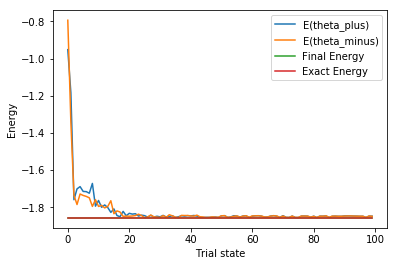

In [5]:
n=2
m=2
device='local_qasm_simulator'

initial_theta=np.zeros(2*n*m)
entangler_map={0: [1]} # the map of two-qubit gates with control at key and target at values
shots=1
max_trials=100
ham_name='H2/H2Equilibrium.txt'

#Exact Energy
pauli_list=Hamiltonian_from_file(ham_name)
H=make_Hamiltonian(pauli_list)
exact=np.amin(la.eig(H)[0]).real
        
    
# Optimization
Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken,Qconfig.config["url"])


eval_hamiltonian_partial=partial(eval_hamiltonian,Q_program,n,m,ham_name,device,shots,H)
eval_hamiltonian_partial(initial_theta)

initial_c=0.1
target_update=2*np.pi*0.1
SPSA_params=SPSA_calibration(eval_hamiltonian_partial,initial_theta,initial_c,target_update,25)

output=SPSA_optimization(eval_hamiltonian_partial,initial_theta,SPSA_params,max_trials,1);
plt.plot(output[2],label='E(theta_plus)')
plt.plot(output[3],label='E(theta_minus)')
plt.plot(np.ones(max_trials)*output[0],label='Final Energy')
plt.plot(np.ones(max_trials)*exact,label='Exact Energy')
plt.legend()
plt.xlabel('Trial state')
plt.ylabel('Energy')

## Optimizing the potential energy surface 

The optimization of the ansatz parameters considered previously 

/Users/amezzac/anaconda/envs/QISKitenv/lib/python3.6/site-packages/ipykernel_launcher.py:63: ComplexWarning: Casting complex values to real discards the imaginary part



OPTIMIZING HAMILTONIAN # 0 AT INTERATOMIC DISTANCE 0.2 ANGSTROM

calibration step # 0 of 5
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
calibrated SPSA_parameters[0] is 1.09582894144
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 0
-0.657129868104
objective function at theta- for step # 0
-0.629599461801
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 75
-2.48531571981
objective function at theta- for step # 75
-2.4853166916
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 80
-2.48523354995
objective function at theta- for step # 80
-2.48549451546
running on backend: local_qasm_simulator
running on backend: local_qasm_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 155
-2.4860165635
objective function at theta- for step # 155
-2.48585348062
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 160
-2.48578693987
obje

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 230
-2.48629401973
objective function at theta- for step # 230
-2.48631959122
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 235
-2.48613959801
objective function at theta- for step # 235
-2.48625345
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qas

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 310
-2.4865536297
objective function at theta- for step # 310
-2.48654715927
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 315
-2.48662076505
objective function at theta- for step # 315
-2.48650179447
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 390
-2.48672849133
objective function at theta- for step # 390
-2.48672843204
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 395
-2.48659988209
obj

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 465
-2.48687133396
objective function at theta- for step # 465
-2.48687698796
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 470
-2.4869306505
objective function at theta- for step # 470
-2.48682802894
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 40
-2.32946872003
objective function at theta- for step # 40
-2.32916098802
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 45
-2.33818385785
objective function at theta- for step # 45
-2.3

running on backend: local_qasm_simulator
objective function at theta+ for step # 115
-2.35888360446
objective function at theta- for step # 115
-2.35912494852
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 120
-2.35928637906
objective function at theta- for step # 120
-2.35912590995
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 195
-2.35948970834
objective function at theta- for step # 195
-2.35949455
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 200
-2.35955008636
objective function at theta- for step # 200
-2.35967243609
running on backend: local_qasm_simulator
running on backend: local_qas

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 275
-2.35960549062
objective function at theta- for step # 275
-2.35975725569
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 280
-2.35990888878
objective function at theta- for step # 280


running on backend: local_qasm_simulator
objective function at theta+ for step # 350
-2.36000100259
objective function at theta- for step # 350
-2.36000426636
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 355
-2.3599366267
objective function at theta- for step # 355
-2.36009273667
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 430
-2.36016237932
objective function at theta- for step # 430
-2.3601463124
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 435
-2.36019220651
objective function at theta- for step # 435
-2.3600050315
running on backend: local_qasm_simulator
running on backend: local_qa

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 0
-0.882967493399
objective function at theta- for step # 0
-0.87629375986
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 5
-1.55647118533
objective function at theta- for step # 5
-1.54990507588
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_si

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 80
-2.22737244921
objective function at theta- for step # 80
-2.22739408978
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 85
-2.22733424455
objective function at theta- for step # 85
-2.22718179476
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 160
-2.22758460942
objective function at theta- for step # 160
-2.22750306384
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 165
-2.22752897656
obj

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 235
-2.22765242205
objective function at theta- for step # 235
-2.22763937666
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 240
-2.22759871249
objective function at theta- for step # 240
-2.22770093986
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 315
-2.22766395185
objective function at theta- for step # 315
-2.22770173212
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 320
-2.22767980654
objective function at theta- for step # 320
-2.2277106492
running on backend: local_q

running on backend: local_qasm_simulator
objective function at theta+ for step # 390
-2.22788937055
objective function at theta- for step # 390
-2.22789975391
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 395
-2.22791127165
objective function at theta- for step # 395
-2.22790766884
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 470
-2.22794884391
objective function at theta- for step # 470
-2.22795605806
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 475
-2.2280417053
objective function at theta- for step # 475
-2.22804117528
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
objective function at theta+ for step # 40
-2.09095963929
objective function at theta- for step # 40
-2.09096863806
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 45
-2.09752362781
objective function at theta- for step # 45
-2.10195998563
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 120
-2.11336416029
objective function at theta- for step # 120
-2.11341556941
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 125
-2.11337346363
objective function at theta- for step # 125
-2.11339936081
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 200
-2.11335191197
objective function at theta- for step # 200
-2.11333844008
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 205
-2.11335861018
objective function at theta- for step # 205


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 275
-2.11344766707
objective function at theta- for step # 275
-2.11342155903
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 280
-2.11338973756
objective function at theta- for step # 280
-2.11336610085
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 355
-2.11338282623
objective function at theta- for step # 355
-2.11337608031
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 360
-2.11337313178
objective function at theta- for step # 360
-2.11338691942
running on backend: local_

running on backend: local_qasm_simulator
objective function at theta+ for step # 430
-2.11339470676
objective function at theta- for step # 430
-2.11337413826
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 435
-2.11339612285
objective function at theta- for step # 435
-2.11338821857
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 5
-0.819685838704
objective function at theta- for step # 5
-0.833365038604
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 10
-1.21210652451
objective function at theta- for step # 10
-1.2

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 85
-1.99679415507
objective function at theta- for step # 85
-1.99689189043
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 90
-1.99712439752
object

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 160
-1.99771346367
objective function at theta- for step # 160
-1.99762063863
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 165
-1.99777751813
objective function at theta- for step # 165
-1.99775667104
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 240
-1.99801699766
objective function at theta- for step # 240
-1.99805512848
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 245
-1.99799525627
objective function at theta- for step # 245


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 315
-1.99804463309
objective function at theta- for step # 315
-1.9980879838
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 320
-1.99812127972
objective function at theta- for step # 320
-1.99816510434
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 395
-1.99816266758
objective function at theta- for step # 395
-1.99819553676
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 400
-1.99812667798
objective function at theta- for step # 400
-1.99812064656
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 475
-1.99814685973
objective function at theta- for step # 475
-1.99815370175
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 480
-1.99819914727
obj

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 45
-1.88660163844
objective function at theta- for step # 45
-1.88604406653
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 50
-1.88697815342
objective function at theta- for step # 50
-1.88715091822
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 125
-1.89110191188
objective function at theta- for step # 125
-1.8911939272
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 130
-1.89111098646
obje

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 200
-1.89166361394
objective function at theta- for step # 200
-1.89156069398
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 205
-1.89162940468
objective function at theta- for step # 205
-1.89147687608
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 280
-1.89186098833
objective function at theta- for step # 280
-1.89175079675
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 285
-1.89185062713
objective function at theta- for step # 285
-1.89189207176
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 360
-1.89196085108
objective function at theta- for step # 360
-1.89188860971
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 365
-1.8919828766
objective function at theta- for step # 365
-

running on backend: local_qasm_simulator
objective function at theta+ for step # 435
-1.89203947644
objective function at theta- for step # 435
-1.89204158091
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 440
-1.89206764624
objective function at theta- for step # 440
-1.89201277334
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 10
-1.24591454386
objective function at theta- for step # 10
-1.24818027676
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 15
-1.29859658035
objective function at theta- for step # 15
-1.3

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 90
-1.78681585328
objective function at theta- for step # 90
-1.78718860926
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 95
-1.78753723161
object

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 165
-1.79294434825
objective function at theta- for step # 165
-1.79242028309
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 170
-1.79270747543
objective function at theta- for step # 170
-1.79316781205
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 245
-1.79464785287
objective function at theta- for step # 245
-1.79432010968
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 250
-1.79444125464
objective function at theta- for step # 250
-1.79461742522
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 325
-1.79527727856
objective function at theta- for step # 325
-1.7951526025
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 330
-1.7952183016
objec

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 400
-1.79544668971
objective function at theta- for step # 400
-1.79533953687
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 405
-1.79543175889
objective function at theta- for step # 405
-1.79536524146
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 480
-1.79544168124
objective function at theta- for step # 480
-1.79548383126
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 485
-1.79555256241
objective function at theta- for step # 485


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 50
-1.69227505053
objective function at theta- for step # 50
-1.69235969165
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 55
-1.69543402235
objective function at theta- for step # 55
-1.69542518075
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 130
-1.70733774875
objective function at theta- for step # 130
-1.70750914957
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 135
-1.70774479894
objective function at theta- for step # 135


running on backend: local_qasm_simulator
objective function at theta+ for step # 205
-1.70830236301
objective function at theta- for step # 205
-1.70823315605
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 210
-1.70835029858
objective function at theta- for step # 210
-1.70827783319
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 285
-1.70847010799
objective function at theta- for step # 285
-1.70839498247
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 290
-1.70849586
objective function at theta- for step # 290
-1.70844499513
running on backend: local_qasm_simulator
running on backend: local_qas

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 365
-1.70849955865
objective function at theta- for step # 365
-1.7084939337
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 370
-1.70846991583
objective function at theta- for step # 370
-

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 440
-1.70847383099
objective function at theta- for step # 440
-1.70846747981
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 445
-1.70850128148
objective function at theta- for step # 445
-1.70850974989
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 15
-1.40331684897
objective function at theta- for step # 15
-1.39986276899
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 20
-1.47293706276
object

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 90
-1.61339212635
objective function at theta- for step # 90
-1.61180041089
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 95
-1.61468321138
objective function at theta- for step # 95
-1.61397316896
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 170
-1.624611969
objective function at theta- for step # 170
-1.62393547346
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 175
-1.62468601077
objective function at theta- for step # 175
-1.62448976769
running on backend: local_qasm_simulator
running on backend: local_qa

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 250
-1.62844570103
objective function at theta- for step # 250
-1.62821593283
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 255
-1.62857004086
obj

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 325
-1.62935396162
objective function at theta- for step # 325
-1.62943670052
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 330
-1.62954715531
objective function at theta- for step # 330
-1.62934590027
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 405
-1.62981024163
objective function at theta- for step # 405
-1.63000308393
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 410
-1.62997627268
objective function at theta- for step # 410


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 480
-1.63019497468
objective function at theta- for step # 480
-1.63005401059
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 485
-1.63017282891
objective function at theta- for step # 485
-1.6301127218
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 55
-1.55614302862
objective function at theta- for step # 55
-1.55658373815
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 60
-1.55892696194
objective function at theta- for step # 60
-1.55911091086
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 135
-1.56025292242
objective function at theta- for step # 135
-1.5602439196
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 140
-1.56020824734
obje

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 210
-1.56024432515
objective function at theta- for step # 210
-1.56024530166
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 215
-1.56024914967
objective function at theta- for step # 215
-1.56024955489
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 290
-1.56020875172
objective function at theta- for step # 290
-1.56020863852
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 295
-1.56024507243
objective function at theta- for step # 295
-1.56024517302
running on backend: local_

running on backend: local_qasm_simulator
objective function at theta+ for step # 365
-1.56021521161
objective function at theta- for step # 365
-1.56021520249
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 370
-1.56024590772
objective function at theta- for step # 370
-1.56024596233
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 445
-1.56022195633
objective function at theta- for step # 445
-1.56022175276
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 450
-1.56024752004
objective function at theta- for step # 450
-1.56024744939
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
objective function at theta+ for step # 15
-1.31991722022
objective function at theta- for step # 15
-1.31960104733
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 20
-1.34994919969
objective function at theta- for step # 20
-1.34845973835
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 95
-1.48586838689
objective function at theta- for step # 95
-1.48654757197
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 100
-1.48732291644
objective function at theta- for step # 100
-1.48744108677
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qa

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 175
-1.4948631389
objective function at theta- for step # 175
-1.4952587669
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 180
-1.49519158268
objective function at theta- for step # 180
-1

running on backend: local_qasm_simulator
objective function at theta+ for step # 250
-1.49710951001
objective function at theta- for step # 250
-1.49711854024
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 255
-1.4972258744
objective function at theta- for step # 255
-1.4970914951
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qa

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 330
-1.49755114814
objective function at theta- for step # 330
-1.49753942309
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 335
-1.49754435104
objective function at theta- for step # 335
-1.49750672606
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 410
-1.49764151365
objective function at theta- for step # 410
-1.49761566695
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 415
-1.49763416469
obj

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 485
-1.49768456499
objective function at theta- for step # 485
-1.49765619012
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 490
-1.49763988641
objective function at theta- for step # 490
-1.49764875861
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 60
-1.40079198725
objective function at theta- for step # 60
-1.40077198149
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 65
-1.40375899414
objective function at theta- for step # 65
-1.4

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 140
-1.43519236713
objective function at theta- for step # 140
-1.43476211469
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 145
-1.43611225921
obj

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 215
-1.43909501936
objective function at theta- for step # 215
-1.4391540455
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 220
-1.4395012639
objective function at theta- for step # 220
-1.4393815639
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qas

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 295
-1.44119701742
objective function at theta- for step # 295
-1.44130736293
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 300
-1.44132484505
objective function at theta- for step # 300
-1.44122373404
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 375
-1.44173204412
objective function at theta- for step # 375
-1.44174040514
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 380
-1.44177051418
objective function at theta- for step # 380


running on backend: local_qasm_simulator
objective function at theta+ for step # 450
-1.44196566601
objective function at theta- for step # 450
-1.44198338957
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 455
-1.44198981648
objective function at theta- for step # 455
-1.44195954801
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 25
-1.32935531164
objective function at theta- for step # 25
-1.32993144506
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 30
-1.34645061667
objective function at theta- for step # 30
-1.3

running on backend: local_qasm_simulator
objective function at theta+ for step # 100
-1.38876477247
objective function at theta- for step # 100
-1.38830063784
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 105
-1.38917526751
objective function at theta- for step # 105
-1.38963374199
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 180
-1.39199930183
objective function at theta- for step # 180
-1.39216512445
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 185
-1.39222742054
objective function at theta- for step # 185
-1.39211442168
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 260
-1.39272744205
objective function at theta- for step # 260
-1.39264145137
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 265
-1.39263118423
objective function at theta- for step # 265


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 335
-1.39286543562
objective function at theta- for step # 335
-1.39299021485
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 340
-1.39292469382
objective function at theta- for step # 340
-1.39291019345
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 415
-1.39305355624
objective function at theta- for step # 415
-1.39306369854
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 420
-1.39307754659
objective function at theta- for step # 420
-1.39309525962
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 495
-1.39317909087
objective function at theta- for step # 495
-1.39317011056
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
Final objective function is: -1.39320130198

OPTIMIZING HAMILTONIAN # 13 AT INTERATOMIC DISTANCE 1.5 ANGSTROM

calibration step # 0 of 5
running

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 65
-1.30843511506
objective function at theta- for step # 65
-1.30852516839
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 70
-1.30917015312
objective function at theta- for step # 70
-1.30893091555
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 145
-1.31312303432
objective function at theta- for step # 145
-1.31297166959
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 150
-1.31335913053
objective function at theta- for step # 150
-1.31331967061
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 225
-1.31730212859
objective function at theta- for step # 225
-1.31712144271
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 230
-1.31754548491
obj

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 300
-1.32023455621
objective function at theta- for step # 300
-1.32020890396
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 305
-1.32046788112
objective function at theta- for step # 305
-1.32055164682
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 380
-1.32362877598
objective function at theta- for step # 380
-1.32354358596
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 385
-1.3237711943
objective function at theta- for step # 385
-1.32368378049
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 460
-1.32689905015
objective function at theta- for step # 460
-1.32681792027
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 465
-1.32686571193
obj

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 30
-1.23199041827
objective function at theta- for step # 30
-1.23190682867
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 35
-1.23211011361
objective function at theta- for step # 35
-1.23217886134
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 110
-1.23264118669
objective function at theta- for step # 110
-1.23261817448
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 115
-1.23260290101
objective function at theta- for step # 115
-1.23258373142
running on backend: local_

running on backend: local_qasm_simulator
objective function at theta+ for step # 185
-1.23266376377
objective function at theta- for step # 185
-1.23266152658
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 190
-1.23262833524
objective function at theta- for step # 190
-1.23266294209
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 265
-1.23264605065
objective function at theta- for step # 265
-1.23265584084
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 270
-1.23265298197
objective function at theta- for step # 270
-1.23265642181
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 345
-1.23268729064
objective function at theta- for step # 345
-1.23267469842
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 350
-1.23268374771
objective function at theta- for step # 350


running on backend: local_qasm_simulator
objective function at theta+ for step # 420
-1.23268966966
objective function at theta- for step # 420
-1.23269556056
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 425
-1.23267287504
objective function at theta- for step # 425
-1.23269198262
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
Final objective function is: -1.23271368597

OPTIMIZING HAMILTONIAN # 15 AT INTERATOMIC DISTANCE 1.7 ANGSTROM

calibration step # 0 of 5
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
calibrated SPSA_parameters[0] is 1.7173048083
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 0
-1.01897662196
objective function at 

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 70
-1.26180141525
objective function at theta- for step # 70
-1.26118320295
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 75
-1.2623543281
objective function at theta- for step # 75
-1.26192541009
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 150
-1.26646087227
objective function at theta- for step # 150
-1.26641574172
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 155
-1.26688228038
objective function at theta- for step # 155
-1.26640287665
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 230
-1.26974489725
objective function at theta- for step # 230
-1.26981738928
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 235
-1.26991277532
obj

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 305
-1.27167319275
objective function at theta- for step # 305
-1.27126675933
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 310
-1.27159044758
objective function at theta- for step # 310
-1.27162549368
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 385
-1.27242004526
objective function at theta- for step # 385
-1.27285850649
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 390
-1.27292338875
objective function at theta- for step # 390


running on backend: local_qasm_simulator
objective function at theta+ for step # 460
-1.27376711868
objective function at theta- for step # 460
-1.27417920282
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 465
-1.27399906202
objective function at theta- for step # 465
-1.27409517163
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 35
-1.21398558465
objective function at theta- for step # 35
-1.21270017774
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 40
-1.21747669128
objective function at theta- for step # 40
-1.2174984276
running on backend: local_qasm_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 115
-1.22227247024
objective function at theta- for step # 115
-1.22236964294
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 120
-1.22238931955
obj

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 190
-1.22461022909
objective function at theta- for step # 190
-1.22454108463
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 195
-1.22457176552
objective function at theta- for step # 195
-1.22461304051
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 270
-1.22658955595
objective function at theta- for step # 270
-1.22656912859
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 275
-1.22663415787
objective function at theta- for step # 275


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 345
-1.22877922711
objective function at theta- for step # 345
-1.22883697652
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 350
-1.22895071093
objective function at theta- for step # 350
-1.22887566126
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 425
-1.23113097273
objective function at theta- for step # 425
-1.23135383986
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 430
-1.23142706109
objective function at theta- for step # 430
-1.23137391336
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
calibrated SPSA_parameters[0] is 2.81701950154
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 0
-0.993077743693
objective function at theta- for step # 0
-0.996840854668
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backen

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 75
-1.22090615875
objective function at theta- for step # 75
-1.22088720075
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 80
-1.22132998221
objective function at theta- for step # 80
-1.22158608831
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 155
-1.22576816811
objective function at theta- for step # 155
-1.22577338881
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 160
-1.22615477613
obj

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 230
-1.22749183318
objective function at theta- for step # 230
-1.22760787807
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 235
-1.22762080178
objective function at theta- for step # 235
-1.22769877131
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 310
-1.228880618
objective function at theta- for step # 310
-1.22885924428
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 315
-1.22899733317
objective function at theta- for step # 315
-1.22896404525
running on backend: local_qa

running on backend: local_qasm_simulator
objective function at theta+ for step # 385
-1.22957237384
objective function at theta- for step # 385
-1.22947194003
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 390
-1.22953945903
objective function at theta- for step # 390
-1.22960982996
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 465
-1.23017813762
objective function at theta- for step # 465
-1.23026477185
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 470
-1.23022429
objective function at theta- for step # 470
-1.23029080158
running on backend: local_qasm_simulator
running on backend: local_qas

running on backend: local_qasm_simulator
objective function at theta+ for step # 35
-1.18900839876
objective function at theta- for step # 35
-1.18895993076
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 40
-1.18904776441
objective function at theta- for step # 40
-1.18917076066
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 115
-1.18920630245
objective function at theta- for step # 115
-1.18922233878
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 120
-1.1892018397
objective function at theta- for step # 120
-1.18918938684
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 195
-1.18926006955
objective function at theta- for step # 195
-1.18929131477
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 200
-1.1892648804
obje

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 270
-1.18930963343
objective function at theta- for step # 270
-1.18930461073
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 275
-1.18934154696
objective function at theta- for step # 275
-1.18930745022
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 350
-1.18938092034
objective function at theta- for step # 350
-1.18934361963
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 355
-1.18932479101
objective function at theta- for step # 355
-1.18932974033
running on backend: local_

running on backend: local_qasm_simulator
objective function at theta+ for step # 425
-1.18940045904
objective function at theta- for step # 425
-1.189432342
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 430
-1.18941463963
objective function at theta- for step # 430
-1.18943466128
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qa

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
calibrated SPSA_parameters[0] is 3.21778047627
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 0
-0.967854510292
objective function at theta- for step # 0
-0.957243514419
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 5
-0.907129088082
objective function at theta- for step # 5
-0.902293661852
running on backend: loca

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 80
-1.1879752262
objective function at theta- for step # 80
-1.18823466846
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 85
-1.18836186425
objecti

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 155
-1.19192378838
objective function at theta- for step # 155
-1.19185742167
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 160
-1.1918762166
objective function at theta- for step # 160
-1.19206958084
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 235
-1.19329467059
objective function at theta- for step # 235
-1.19326458666
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 240
-1.19331331211
objective function at theta- for step # 240


running on backend: local_qasm_simulator
objective function at theta+ for step # 310
-1.1939940374
objective function at theta- for step # 310
-1.19383054813
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 315
-1.19398373932
objective function at theta- for step # 315
-1.19392062066
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 390
-1.19433137407
objective function at theta- for step # 390
-1.19421215793
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 395
-1.19424989636
objective function at theta- for step # 395
-1.19425994549
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 470
-1.19456127231
objective function at theta- for step # 470
-1.19446414795
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 475
-1.19447878136
objective function at theta- for step # 475


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 40
-1.17167541006
objective function at theta- for step # 40
-1.1715903334
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 45
-1.1719732938
objective function at theta- for step # 45
-1.17172565849
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_s

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 120
-1.17331720798
objective function at theta- for step # 120
-1.17337195096
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 125
-1.17336620425
objective function at theta- for step # 125


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 195
-1.17379791974
objective function at theta- for step # 195
-1.1736896055
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 200
-1.17378294158
objective function at theta- for step # 200
-1.17380415421
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 275
-1.17414955264
objective function at theta- for step # 275
-1.17409037883
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 280
-1.17410426689
objective function at theta- for step # 280
-1.1741294983
running on backend: local_q

running on backend: local_qasm_simulator
objective function at theta+ for step # 350
-1.17449046885
objective function at theta- for step # 350
-1.1744449327
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 355
-1.17457418735
objective function at theta- for step # 355
-1.1743544892
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qa

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 430
-1.17467574126
objective function at theta- for step # 430
-1.17477422742
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 435
-1.17471939565
objective function at theta- for step # 435
-1.17470206822
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 0
-0.940236451256
objective function at theta- for step # 0
-0.932909118619
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 5
-0.896058302982
objective function at theta- for step # 5
-0.899867340084
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 80
-1.16161909412
objective function at theta- for step # 80
-1.16164532373
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 85
-1.16162796845
objective function at theta- for step # 85
-1.16161121508
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 160
-1.16164012048
objective function at theta- for step # 160
-1.16163798919
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 165
-1.16164561314
objective function at theta- for step # 165


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 235
-1.16165232124
objective function at theta- for step # 235
-1.16164706039
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 240
-1.16167208226
objective function at theta- for step # 240
-1.16167068287
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 315
-1.16169954933
objective function at theta- for step # 315
-1.161698612
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 320
-1.16171319379
objective function at theta- for step # 320
-1.16167823301
running on backend: local_qa

running on backend: local_qasm_simulator
objective function at theta+ for step # 390
-1.16171723745
objective function at theta- for step # 390
-1.16173895928
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 395
-1.16173021609
objective function at theta- for step # 395
-1.16171107429
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 470
-1.16175846825
objective function at theta- for step # 470
-1.16177253356
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 475
-1.16176198717
objective function at theta- for step # 475
-1.16173982623
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 40
-1.15000346784
objective function at theta- for step # 40
-1.14986652103
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 45
-1.15004545627
objective function at theta- for step # 45
-1.15016951144
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 120
-1.15102630082
objective function at theta- for step # 120
-1.15095728009
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 125
-1.15101210639
objective function at theta- for step # 125
-1.15104071528
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 195
-1.15108955358
objective function at theta- for step # 195
-1.15114263496
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 200
-1.15113851462
objective function at theta- for step # 200
-1.15114398659
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 275
-1.15122477474
objective function at theta- for step # 275
-1.15121936757
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 280
-1.15120704174
objective function at theta- for step # 280


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 350
-1.15128081288
objective function at theta- for step # 350
-1.15128175533
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 355
-1.15126540175
objective function at theta- for step # 355
-1.15125358664
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 430
-1.15132064994
objective function at theta- for step # 430
-1.15131340428
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 435
-1.15133771319
objective function at theta- for step # 435
-1.15132929394
running on backend: local_

running on backend: local_qasm_simulator
objective function at theta+ for step # 0
-0.912146005731
objective function at theta- for step # 0
-0.914627436848
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 5
-0.703147751155
objective function at theta- for step # 5
-0.70045574029
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 80
-1.14323814112
objective function at theta- for step # 80
-1.14324722503
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 85
-1.14321211698
objective function at theta- for step # 85
-1.14319704946
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 160
-1.14329546497
objective function at theta- for step # 160
-1.1432716091
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 165
-1.14329535688
objective function at theta- for step # 165
-

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 235
-1.14324220528
objective function at theta- for step # 235
-1.14324975035
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 240
-1.14330015622
objective function at theta- for step # 240
-1.14330312633
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 315
-1.14330977097
objective function at theta- for step # 315
-1.1433005915
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 320
-1.14331406715
objective function at theta- for step # 320
-1.1433055807
running on backend: local_qa

running on backend: local_qasm_simulator
objective function at theta+ for step # 390
-1.14331784638
objective function at theta- for step # 390
-1.14331440925
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 395
-1.14330003823
objective function at theta- for step # 395
-1.14329488863
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 470
-1.14331186228
objective function at theta- for step # 470
-1.14330923825
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 475
-1.14330773776
objective function at theta- for step # 475
-1.14331277136
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
objective function at theta+ for step # 40
-1.13706329751
objective function at theta- for step # 40
-1.13703491211
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 45
-1.13716569274
objective function at theta- for step # 45
-1.13704329993
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 120
-1.13757054104
objective function at theta- for step # 120
-1.13760942643
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 125
-1.13764160308
objective function at theta- for step # 125
-1.137700543
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qa

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 200
-1.13772304459
objective function at theta- for step # 200
-1.13772356618
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 205
-1.1377357279
objective function at theta- for step # 205
-

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 275
-1.13770071023
objective function at theta- for step # 275
-1.13770820877
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 280
-1.13771945987
objective function at theta- for step # 280
-1.13772202203
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 355
-1.13777835554
objective function at theta- for step # 355
-1.13777572147
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 360
-1.13775710838
objective function at theta- for step # 360
-1.13778295843
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 435
-1.13779269905
objective function at theta- for step # 435
-1.13778051313
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 440
-1.1377980436
obje

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 5
-0.876939208553
objective function at theta- for step # 5
-0.888743780742
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 10
-1.06524218624
objective function at theta- for step # 10
-1.06677266834
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 85
-1.12803569608
objective function at theta- for step # 85
-1.12803544535
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 90
-1.12804076883
objective function at theta- for step # 90
-1.1

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 160
-1.12802714359
objective function at theta- for step # 160
-1.1280305876
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 165
-1.12803130708
objective function at theta- for step # 165
-1.12803227135
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 240
-1.12801779845
objective function at theta- for step # 240
-1.12801928794
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 245
-1.12806089539
objective function at theta- for step # 245


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 315
-1.12805416979
objective function at theta- for step # 315
-1.12805252546
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 320
-1.12805958383
objective function at theta- for step # 320
-1.12805600245
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 395
-1.12804211903
objective function at theta- for step # 395
-1.12804478771
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 400
-1.12803839624
objective function at theta- for step # 400
-1.12804193442
running on backend: local_

running on backend: local_qasm_simulator
objective function at theta+ for step # 470
-1.12805567987
objective function at theta- for step # 470
-1.12805413945
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 475
-1.12806448786
objective function at theta- for step # 475
-1.12805974618
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 45
-1.11913526246
objective function at theta- for step # 45
-1.11860259044
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 50
-1.11933875945
objective function at theta- for step # 50
-1.1

running on backend: local_qasm_simulator
objective function at theta+ for step # 120
-1.12054600904
objective function at theta- for step # 120
-1.12059988886
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 125
-1.12056708586
objective function at theta- for step # 125
-1.12067666982
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 200
-1.12097709775
objective function at theta- for step # 200
-1.12097773577
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 205
-1.12103757611
objective function at theta- for step # 205
-1.1209858682
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 280
-1.12119378282
objective function at theta- for step # 280
-1.12117189362
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 285
-1.12122998119
objective function at theta- for step # 285


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 355
-1.12121464857
objective function at theta- for step # 355
-1.12118775782
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 360
-1.12123238118
objective function at theta- for step # 360
-1.12127428622
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 435
-1.12130683758
objective function at theta- for step # 435
-1.12133121744
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 440
-1.1213124369
objective function at theta- for step # 440
-1.12133110036
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 5
-0.927583598174
objective function at theta- for step # 5
-0.927914565463
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 10
-1.10050953615
objective function at theta- for step # 10
-1.10192414767
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 85
-1.11529407757
objective function at theta- for step # 85
-1.11529155763
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 90
-1.11529860239
objective function at theta- for step # 90
-1.11529851913
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 165
-1.11531344871
objective function at theta- for step # 165
-1.11531283853
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 170
-1.11526724236
objective function at theta- for step # 170


running on backend: local_qasm_simulator
objective function at theta+ for step # 240
-1.11527159994
objective function at theta- for step # 240
-1.11527335055
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 245
-1.11529375981
objective function at theta- for step # 245
-1.11529236056
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 320
-1.11529719641
objective function at theta- for step # 320
-1.11529892468
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 325
-1.11527953747
objective function at theta- for step # 325
-1.1152789426
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 400
-1.11529128405
objective function at theta- for step # 400
-1.1152912807
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 405
-1.11528597344
obje

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 475
-1.11529925743
objective function at theta- for step # 475
-1.11529688433
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 480
-1.11530253758
objective function at theta- for step # 480
-1.11530285564
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 50
-1.10924288255
objective function at theta- for step # 50
-1.10931196249
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 55
-1.10926648802
object

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 125
-1.1093223638
objective function at theta- for step # 125
-1.10932346643
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 130
-1.10931436829
objective function at theta- for step # 130
-1.10931623464
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 205
-1.10930024439
objective function at theta- for step # 205
-1.10930025784
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 210
-1.10931778832
objective function at theta- for step # 210
-1.10931725099
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 285
-1.10931886103
objective function at theta- for step # 285
-1.10931841549
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 290
-1.10931797107
objective function at theta- for step # 290


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 360
-1.10931973729
objective function at theta- for step # 360
-1.10931917575
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 365
-1.10931921923
objective function at theta- for step # 365
-1.10931978681
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 440
-1.10932044826
objective function at theta- for step # 440
-1.10931980555
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 445
-1.10927116923
objective function at theta- for step # 445
-1.10927173458
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 10
-1.09346359576
objective function at theta- for step # 10
-1.09476624469
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 15
-1.09871614111
objective function at theta- for step # 15
-1.09890369517
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 90
-1.10375647098
objective function at theta- for step # 90
-1.10376003412
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 95
-1.10375498813
objective function at theta- for step # 95
-1.10375500242
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 170
-1.10375611162
objective function at theta- for step # 170
-1.10375452083
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 175
-1.10376419863
objective function at theta- for step # 175


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 245
-1.10375555263
objective function at theta- for step # 245
-1.10375776204
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 250
-1.10370046524
objective function at theta- for step # 250
-1.10370226336
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 325
-1.10376688226
objective function at theta- for step # 325
-1.10376549194
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 330
-1.10375446569
objective function at theta- for step # 330


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 400
-1.10376066288
objective function at theta- for step # 400
-1.10376049651
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 405
-1.10376398911
objective function at theta- for step # 405
-1.10376241774
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 480
-1.10375926535
objective function at theta- for step # 480
-1.10375800533
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 485
-1.10374342698
objective function at theta- for step # 485
-1.10374294632
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 50
-1.09803896848
objective function at theta- for step # 50
-1.09802959182
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 55
-1.09810979951
objective function at theta- for step # 55
-1.09812339356
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 130
-1.09846331627
objective function at theta- for step # 130
-1.0984897287
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 135
-1.09852947583
objective function at theta- for step # 135
-1.09846747494
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 210
-1.09854970769
objective function at theta- for step # 210
-1.09853105363
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 215
-1.09854000531
obj

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 285
-1.09851753058
objective function at theta- for step # 285
-1.09852866746
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 290
-1.09858518572
objective function at theta- for step # 290
-1.09857161768
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 365
-1.09858313772
objective function at theta- for step # 365
-1.09858417336
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 370
-1.09858183489
objective function at theta- for step # 370


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 440
-1.09857016941
objective function at theta- for step # 440
-1.09856572104
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 445
-1.09858740556
objective function at theta- for step # 445
-1.0985873921
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 15
-1.08901238397
objective function at theta- for step # 15
-1.09028475689
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 20
-1.09278473492
object

running on backend: local_qasm_simulator
objective function at theta+ for step # 90
-1.09342711155
objective function at theta- for step # 90
-1.09342365794
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 95
-1.09336894689
objective function at theta- for step # 95
-1.09337155501
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 170
-1.09343404882
objective function at theta- for step # 170
-1.09343400888
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 175
-1.09342738101
objective function at theta- for step # 175
-1.09342698098
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 250
-1.0934370163
objective function at theta- for step # 250
-1.09343682973
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 255
-1.09343612502
obje

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 325
-1.09342004663
objective function at theta- for step # 325
-1.09342008104
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 330
-1.09345561718
objective function at theta- for step # 330
-1.09345562116
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 405
-1.09340411756
objective function at theta- for step # 405
-1.09340427723
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 410
-1.09340443286
obj

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 480
-1.09342314953
objective function at theta- for step # 480
-1.09342308619
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 485
-1.09343344753
objective function at theta- for step # 485
-1.09343316607
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 55
-1.08814457101
objective function at theta- for step # 55
-1.08803738314
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 60
-1.08810631125
object

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 130
-1.08864883031
objective function at theta- for step # 130
-1.08855543042
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 135
-1.08857589138
objective function at theta- for step # 135
-1.08860806887
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 210
-1.08869583779
objective function at theta- for step # 210
-1.08876007135
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 215
-1.08870367415
objective function at theta- for step # 215
-1.08874629245
running on backend: local_

running on backend: local_qasm_simulator
objective function at theta+ for step # 285
-1.088780473
objective function at theta- for step # 285
-1.08880791062
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 290
-1.08879924344
objective function at theta- for step # 290
-1.0887405064
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qas

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 365
-1.0888177598
objective function at theta- for step # 365
-1.08877718493
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 370
-1.08882591542
objective function at theta- for step # 370
-1.08883640673
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 445
-1.08885345089
objective function at theta- for step # 445
-1.08884407017
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 450
-1.08880667129
objective function at theta- for step # 450


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 15
-1.08334816376
objective function at theta- for step # 15
-1.0832080334
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 20
-1.08431171381
objective function at theta- for step # 20
-1.08412747441
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 95
-1.08431862972
objective function at theta- for step # 95
-1.08431703041
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 100
-1.08431902769
objective function at theta- for step # 100
-1.08431832371
running on backend: local_qa

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 175
-1.08433865262
objective function at theta- for step # 175
-1.08433834775
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 180
-1.08431502095
obj

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 250
-1.08431884946
objective function at theta- for step # 250
-1.08431927923
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 255
-1.08429759704
objective function at theta- for step # 255
-1.08429643351
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 330
-1.08432286497
objective function at theta- for step # 330
-1.08432340827
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 335
-1.08430898464
objective function at theta- for step # 335
-1.08430969597
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 410
-1.08432454428
objective function at theta- for step # 410
-1.08432329863
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 415
-1.08429299174
obj

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 485
-1.08431141748
objective function at theta- for step # 485
-1.08431193605
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 490
-1.08432106689
objective function at theta- for step # 490
-1.08432083749
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 60
-1.07988542404
objective function at theta- for step # 60
-1.07981621045
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 65
-1.07983344465
object

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 135
-1.08006592328
objective function at theta- for step # 135
-1.07999120339
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 140
-1.08004301252
objective function at theta- for step # 140
-1.08003782891
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 215
-1.08004539764
objective function at theta- for step # 215
-1.0800811761
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 220
-1.08011684806
objective function at theta- for step # 220
-1.08008639892
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 295
-1.08012943779
objective function at theta- for step # 295
-1.08013462221
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 300
-1.08012684908
objective function at theta- for step # 300


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 370
-1.08010965227
objective function at theta- for step # 370
-1.08011128047
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 375
-1.08011561881
objective function at theta- for step # 375
-1.08010593395
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 450
-1.08015055438
objective function at theta- for step # 450
-1.08014550432
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 455
-1.08015853668
objective function at theta- for step # 455
-1.08015385266
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 20
-1.07600728157
objective function at theta- for step # 20
-1.07599372688
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 25
-1.075980659
objective function at theta- for step # 25
-1.0757682916
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_si

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 100
-1.0761507099
objective function at theta- for step # 100
-1.07614816727
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 105
-1.07614881106
objective function at theta- for step # 105
-1.07614623737
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
objective function at theta+ for step # 175
-1.07614932188
objective function at theta- for step # 175
-1.07614992199
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 180
-1.07614501846
objective function at theta- for step # 180
-1.07614547203
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 255
-1.0761681253
objective function at theta- for step # 255
-1.07616803231
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 260
-1.07615257149
objective function at theta- for step # 260
-1.07615304796
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 335
-1.07614040705
objective function at theta- for step # 335
-1.07614043709
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 340
-1.07610251083
objective function at theta- for step # 340


running on backend: local_qasm_simulator
objective function at theta+ for step # 410
-1.076152057
objective function at theta- for step # 410
-1.0761520581
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 415
-1.07616057732
objective function at theta- for step # 415
-1.0761607381
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 490
-1.07614637351
objective function at theta- for step # 490
-1.07614659264
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 495
-1.07615804412
objective function at theta- for step # 495
-1.07615772297
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 60
-1.07239557039
objective function at theta- for step # 60
-1.07239567947
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 65
-1.07235144438
objective function at theta- for step # 65
-1.07235233307
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 140
-1.07236132253
objective function at theta- for step # 140
-1.07236105902
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 145
-1.07235628658
objective function at theta- for step # 145
-1.07235575335
running on backend: local_

running on backend: local_qasm_simulator
objective function at theta+ for step # 215
-1.07233549292
objective function at theta- for step # 215
-1.07233542189
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 220
-1.07238594445
objective function at theta- for step # 220
-1.07238542852
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 295
-1.07240850003
objective function at theta- for step # 295
-1.07240854402
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 300
-1.0723405538
objective function at theta- for step # 300
-1.07234063503
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 375
-1.07239051131
objective function at theta- for step # 375
-1.07238995949
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 380
-1.07239701293
objective function at theta- for step # 380


running on backend: local_qasm_simulator
objective function at theta+ for step # 450
-1.07234819812
objective function at theta- for step # 450
-1.07234806113
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 455
-1.07240267857
objective function at theta- for step # 455
-1.07240306865
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 25
-1.06880800197
objective function at theta- for step # 25
-1.0688081639
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 30
-1.06876221989
objective function at theta- for step # 30
-1.06876978804
running on backend: local_qasm_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 105
-1.06881132136
objective function at theta- for step # 105
-1.06881163748
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 110
-1.06881635362
obj

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 180
-1.06881963871
objective function at theta- for step # 180
-1.0688198862
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 185
-1.06882758674
objective function at theta- for step # 185
-1.06882755976
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 260
-1.06883968392
objective function at theta- for step # 260
-1.06883907875
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 265
-1.06879134077
objective function at theta- for step # 265
-1.06879142324
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 340
-1.06882122825
objective function at theta- for step # 340
-1.06882137319
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 345
-1.06879106328
objective function at theta- for step # 345


running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 415
-1.06881268623
objective function at theta- for step # 415
-1.06881236798
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 420
-1.06883284405
objective function at theta- for step # 420
-1.06883253032
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 495
-1.0688208095
objective function at theta- for step # 495
-1.06882110364
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
Final objective function is: -1.06885032962

OPTIMIZING HAMILTONIAN # 38 AT INTERATOMIC DISTANCE 4.0 ANGSTROM

calibration step # 0 of 5
running 

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 65
-1.06545462934
objective function at theta- for step # 65
-1.06540285374
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 70
-1.06538394127
objective function at theta- for step # 70
-1.06537387115
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 145
-1.06542771527
objective function at theta- for step # 145
-1.06542770574
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 150
-1.06543415666
objective function at theta- for step # 150
-1.06543411117
running on backend: local_

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 225
-1.06543616558
objective function at theta- for step # 225
-1.06543611668
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 230
-1.06544094334
obj

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 300
-1.06544422338
objective function at theta- for step # 300
-1.06544393008
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 305
-1.06542281897
objective function at theta- for step # 305
-1.0654229162
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 380
-1.06544357833
objective function at theta- for step # 380
-1.06544329978
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 385
-1.0654336511
objective function at theta- for step # 385
-1.06543389021
running on backend: local_qasm_simulator
running on backend: local_q

running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 460
-1.06545623713
objective function at theta- for step # 460
-1.06545631129
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
running on backend: local_qasm_simulator
objective function at theta+ for step # 465
-1.06542715891
obj

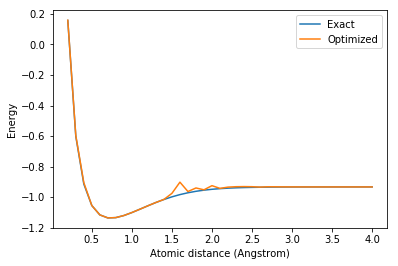

In [17]:
# MOLECULE PARAMETERS

molecule='H2' #name of the molecule: options are H2 or LiH

if molecule=='H2':
    n=2 # qubits
    Z1=1
    Z2=1
    min_distance=.2
    max_distance=4
    number_of_points=39
elif molecule=='LiH':
    n=4 # qubits
    Z1=1
    Z2=3
    min_distance=.5
    max_distance=5
    number_of_points=46
    
    
# OPTIMIZATION PARAMETERS 

run_optimization='Yes' # Choose 'Yes' or 'No'

m=2 # depth (number of layers of sq gates - # entanglers is this number -1)
device='local_qasm_simulator'
initial_theta=np.random.randn(2*n*m)  # initial angles 
entangler_map={0: [1]} # the map of two-qubit gates with control at key and target at values
shots=1
max_trials=500

initial_c=0.01
target_update=2*np.pi*0.1





####################     COMPUTING FOR THE POTENTIAL ENERGY SURFACE      ###################

mol_distance=np.zeros(number_of_points)
coulomb_repulsion=np.zeros(number_of_points)
electr_energy=np.zeros(number_of_points)
electr_energy_optimized=np.zeros(number_of_points)

Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken,Qconfig.config["url"])

for i in range(number_of_points):

    
    # %%%%%%%%%%%%% Coulomb Repulsion For Diatomic molecules %%%%%%%%%%%%%%%%%%%%%%
        mol_distance[i]=np.around((min_distance+(max_distance-min_distance)*i/(number_of_points-1)),2)
        
        distance=mol_distance[i]/0.529177
        coulomb_repulsion[i]=Z1*Z2/distance
        
    # exact diagonalization
        ham_text=molecule+'/PESMap'+str(i)+'atdistance'+str(mol_distance[i])+'.txt'
        pauli_list=Hamiltonian_from_file(ham_text)
        H=make_Hamiltonian(pauli_list)
        eigen=la.eig(H)
        electr_energy[i]=np.amin(eigen[0])
        
        
        
    # optimization
    
        if run_optimization=='Yes':
            print('\nOPTIMIZING HAMILTONIAN # '+str(i)+' AT INTERATOMIC DISTANCE '+str(mol_distance[i])+' ANGSTROM\n')
            eval_hamiltonian_partial=partial(eval_hamiltonian,Q_program,n,m,ham_name,device,shots,H)
            SPSA_params=SPSA_calibration(eval_hamiltonian_partial,initial_theta,initial_c,target_update,5)
            electr_energy_optimized[i]=SPSA_optimization(eval_hamiltonian_partial,initial_theta,SPSA_params,max_trials,5)[0]
            


plt.plot(mol_distance,electr_energy+coulomb_repulsion,label='Exact')
plt.plot(mol_distance,electr_energy_optimized+coulomb_repulsion,label='Optimized') 
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
        